<a href="https://colab.research.google.com/github/leolorenzoii/ml2_interpretability/blob/main/notebooks/01_Model_Interpretability_and_Shapley_Values.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" align="left" alt="Open In Colab"/>
</a>

# Model Interpretability and Shapley Values

Throughout the **Machine Learning 1** course, we have learned all about different machine learning algorithms and how they work and tune them. In a nutshell, we have been able to train a machine learning model and use it to make predictions on unseen data (see Figure <a href='#fig:ml-nutshell'>1</a>).

<a name='fig:ml-nutshell'></a>
<div>
<img src="images/ml-nutshell.png" align="left" width="600"/>
</div>

<br style="clear:both" />

<div>
    <p style="font-size:12px;font-style:default;">
        <b>Figure 1. Training and testing a machine learning model in a nutshell.</b><br>
        We learned how to train a machine learning model and use it to predict unseen data.
    </p>
</div>

<br style="clear:both" />

However, when it comes to choosing the optimal model, often the most accurate ones are the least interpretable (see Figure <a href='#fig:accuracy-interpretability'>2</a>) [[1]](#ref:interpret-ml).

<a name='fig:accuracy-interpretability'></a>
<div>
<img src="images/accuracy-interpretability-trade-off.PNG" align="left" width="450"/>
</div>

<br style="clear:both" />

<div>
    <p style="font-size:12px;font-style:default;">
        <b>Figure 2. Machine learning model accuracy and interpretability tradeoff.</b><br>
           Models that are highly accurate are the least interpretable, while models that are highly interpretable have a sub-par accuracy [<a href='#ref:interpret-ml'>1</a>].
    </p>
</div>

Linear models offer the highest interpretability but offer sub-par accuracy. Tree-based ensemble models such as Random Forest and Gradient Boosted trees offer top accuracy but interpretation is limited to knowing the most important features used by the model.

We are left with several unanswered questions such as:

- How does one (or more) feature impact the predictions of the model?
- What is the role that each feature value play in each individual predictions?
- How can we explain the models predictions in a more useful manner for our stakeholders?

We will deal with such questions in this notebook. In particular, we will discuss how we can interpret better our models predictions with focus on the concept of **Shapley Values**. We will first enrich our background by discussing core concepts of model interpretability then discuss Shapley values and how we can use it to interpret our model's prediction.

## What is model interpretability?

In Christoph Molnar's [Interpretable Machine Learning](#ref:molnar) book [[2]](#ref:molnar), he collated two definitions of **interpretability**. A non-mathematical one:

> *Interpretability is the degree to which a* ***human*** *can* ***understand*** *the cause of a* ***decision***. [[3]](#ref:miller)

And a mathematical one:

> *Interpretability is the degree to which a* ***human*** *can consistently* ***predict*** *the* ***model’s result***. [[4]](#ref:kim)

In both definitions we see three important elements: the **human**, the **understanding**, and the **decision**. Thus, in the same way, when we construct our definition for *interpretability* in the context of machine learning:

> ***Model interpretability*** *refers to the degree in which the behaviors and predictions of machine learning models are understandable to humans.*

Notice here that there is a *flexibility* in the definition of model interpretability. Indeed, defining how explicable a machine learning model is depends on the needs and requirements of a project and the different stakeholders.

Nevertheless, as ethical machine learning practitioners and data science leaders, model interpretability MUST be integrated as early as possible in the development process and should NOT just be taken as an afterthought. Following the CRISP-DM framework [[5]](#ref:crisp-dm), model interpretability requirements must be deliberated during the first phase of the project and implemented during model evaluation and deployment (see Figure [3](#fig:crisp-dm)).

<a name='fig:crisp-dm'></a>
<div>
<img src="images/crisp-dm-interpretability.png" align="left" width="450"/>
</div>

<br style="clear:both" />

<div>
    <p style="font-size:12px;font-style:default;">
        <b>Figure 3. Model interpretability integrated in the CRISP-DM machine learning project lifecycle.</b><br>
           Model interpretability requirements must be deliberated during the first phase of the project and be implemented during model evaluation and deployment.
    </p>
</div>


### Why interpretability?

Now, one might ask, why bother with interpretability? Wouldn't a high model performance would ultimately yield to higher business value? This is quite a arguable topic and in fact, in 2017, the [Neural Information Processing Systems](https://nips.cc/) conference in 2017 had its first ever ***The Great AI Debate*** with the topic ***Is interpretability necessary for machine learning?*** [[6]](#ref:great-ai-debate) *(you are highly encourage to watch this engaging and insightful discussion* 🙂).

In the video, it was shown that model interpretability is crucial especially for some applications where quirky patterns from the data may be learned by the model. Indeed, having an interpretability pipeline in your project gives you, as the Data Scientist the ability to debug your model and identify issues early on, thus, giving you a chance to improve your model. Furthermore, it has added benefits for other stakeholders that is interested and affected by your machine learning model (see Figure [4](#fig:stakeholders)).

<a name='fig:stakeholders'></a>
<div>
<img src="images/interpretability-stakeholders.png" align="left" width="700"/>
</div>

<br style="clear:both" />
<br style="clear:both" />

<div>
    <p style="font-size:12px;font-style:default;">
        <b>Figure 4. Benefits of model interpretability to various stakeholders of a machine learning project.</b><br>
           Model interpretability benefits the data scientist, business decision makers, approving authorities, and business customers.
    </p>
</div>

For **data scientists**, being able to explain the model to other stakeholders is also one benefit of having model explicability. The better you can explain the model to other people in the business, the greater its chance of being adopted and the trust given to the model by other stakeholders. With model interpretability, **business executives** now has the option to provide transparency to its end-users. Furthermore, it helps them justify the business case for the investment and identify other potential extensions and business use-case for the project. **Approving authorities** also benefit from model interpretability, by having a clear understanding of the risk the business is going to take in adopting the model, understanding the impact of the model decisions to humans, and anticipate any legal or regulatory issues that the model may face. Finally, **customer** experience and decision making can also be improved if they understand why a model gives a certain prediction.

<div class="alert alert-info">

**Points for Discussion**

Here, we outlined the benefits of having an interpretability pipeline in our machine learning projects. Can you think of cases where having model interpretability is NOT preferred? Give a particular instance where having model interpretability can do more harm than good.

</div>

### What makes a good explanation

Before we begin explaining predictions of machine learning models, it helps to understand what makes an explanation good an acceptable for humans. We are making explanations, after all, for a humans to be digested. This help us better frame the model explanations we get from model interpretability methods.

Here are some of the few important characteristics of a good explanation *(see Chapter 3.6 of Molnar's Interpretable Machine Learning for a complete list [[2]](#ref:molnar))*:

1. **Contrastive** - Model explanations must be able to answer *why a given prediction has been made in place of another prediction*. For example, in a model that recommends whether an individual be given a loan or not, a good explanation must be able to tell *what factors should/could I change to alter the model prediction*.
2. **Selective** - We *humans are only capable to comprehend 2 to 3 variables at a time*. Thus, a good model explanation must be able to *list the important drivers to explain an outcome*. Imagine having an interpretable model such as linear regression or decision trees, but an explanation that looks at hundreds or thousands of variables, it would be really hard for any human to digest that explanation!
3. **Consistent with prior beliefs** - Model explanations are greatly affected by how people perceived them. As such, when *an explanation is consistent with the prior beliefs of an individual*, they tend to favor such explanation ( also known as **confirmation bias**). This is not to discredit any novel or serendipitous discoveries of the model explanation. However, having an explanation that is in line with a domain expert, helps in the model's adoption. Furthermore, if a model is found to exhibit behavior inconsistent with the domain expert's belief, we can enforce constraints on the model or use a linear model that has the required property.

<div class="alert alert-info">

**Points for Discussion**

Among the interpretability methods that you currently know, can you create model explanations that satisfies all of the three characteristics we discussed above?

</div>

### Types of Explainability Methods

Model interpretability methods can be classified according to three different criteria (see Figure 5) [[7]](#ref:bbox-peek):

<a name='fig:taxonomy'></a>
<div>
<img src="images/taxonomy.png" align="left" width="550"/>
</div>

<br style="clear:both" />
<br style="clear:both" />

<div>
    <p style="font-size:12px;font-style:default;">
        <b>Figure 5. Taxonomy of different explainability methods.</b><br>
           Model interpretability or explainability methods can be intrinsic or post-hoc, model-specific or model-agnostic, local or global. Model-agnostic methods can be further classified whether they use surrogate models or are just visualizations of the behavior of the black-box model.
    </p>
</div>

First, we can classify whether the method stems from the model being **intrinsically** interpretable. If the model is not intrinsically interpretable, then the explanation method can be applied **post-hoc** or post-model training. Examples of intrinsically interpretable models include: Linear models, Decision Tree, and Rule-based models ([RuleFit](https://github.com/rohan-gt/rulefit) [[8]](#ref:rulefit)).

We can further classify the method whether it is **model-specific** or **model-agnostic** (intrinsic explainability methods are model-specific by definition). Model agnostic means that the explainability method can be applied to any black box models. They can be further divided into whether they apply **surrogate** models (e.g., LIME or SHAP Kernel) or is a **visualization** of the behavior of the black box model (e.g., Partial Dependence Plots, Individual Conditional Expectations, or Accumulated Local Effects) [[9]](#ref:med-image).

Finally, we can classify an explainability method whether it is a **global** explanation - i.e., it explains the whole model behavior (ex. feature importance and summary visualizations), or whether it is a **local** explanation, i.e., it explains a particular instance in the test or train dataset.

## Shapley Values

The **Shapley values** is a hallmark concept in the field of cooperative game-theory. As applied to machine learning model interpretability, it gives a key insights in defining feature importance and the roles each feature play in a prediction. *The Shapley value is the only explanation method grounded on a* ***solid theory*** and ensures that difference between the *average prediction* is fairly distributed among the feature values of the instance. This is one key advantage of Shapley values, and in situations where regulations or law require explainability, Shapley might be the only legal compliant explainability method [[2]](#ref:molnar).

It is by nature a local explanation method, but due to its characteristic, it can also be used for global explanations. The contrastive explanations it provides, coupled with its flexibility and practicality, makes explanaibility methods based from Shapley values highly popular. 

### Definition and Demonstration

Shapley values is a solution in cooperative game-theory answering how to distribute a **gain** of a **coalition** *fairly* by considering the outcome of each possible combination (or coalition) of **players** to determine the importance of each player. The distribution is based on the **expected marginal contribution** of a player when it joins the coalition (at every possible ordering).

To understand the significance of Shapley values and how it is computed, let us consider the following demonstration [[10]](#ref:shap-how):

Say that in a certain RPG game, a Dragon Quest was offered by a certain dungeon master:

<img src="images/dragon_quest/1.png" align="center" width="250"/>

*\"For every dragon tamed, your team gets a thousand gold coins\"* the Dungeon Master said.

Heeding the call of this dragon quest are the band of brave adventurers: The (1) Fiesty Sorcerres, (2) Mighty Knight, and the (3) Keen Archer.

<img src="images/dragon_quest/2.png" align="center" width="400"/>

For the duration of the quest, the three tamed *30 dragons* granting them a total bounty of *30 thousand gold*!

Initially, the team thought of distributing the bounty *evenly*, granting each member a take-home bounty of *10 thousand gold* each. However, the Fiesty Sorceress reacted: *\"It is my spells that weaken the dragons that we encountered, I think it is not fair that I don't get a bonus in the bounty that we have!\"*

This presents a dillema, since giving the Fiesty Sorceress a bonus means cutting the share of some of the other members. The question now is: ***Is there any truth to the claim of the Fiesty Sorceress? How should we distribute the bounty fairly among the members of the team?***

Here is where the Shapley values becomes useful. By considering the *expected marginal contribution* of each member as they enter the coalition in all possible ordering, we can compute for the amount of bounty that each player should receive.

As a demonstration, let's compute the Shapley value of the Fiesty Sorceress and see if there's any truth to her claim.

<img src="images/dragon_quest/3.png" align="center" width="450"/>

The Fiesty Sorceress can enter the coalition in four different scenarios: (1) Coming from **No Members** $\varnothing$ to a single player (Fiesty Sorceress); (2) Joining the **Brave Knight** forming a party of 2 (Brave Knight, Fiesty Sorceress); (3) Joining the **Keen Archer** forming a party of 2 (Keen Archer, Fiesty Sorceress); and (4) Joining the team of **Brave Knight and Keen Archer** forming a party of 3 (Brave Knight, Keen Archer, Fiesty Sorceress).

We then compute the **marginal contribution** of the Fiesty Sorceress as she enters the coalition from these four scenarios:

1. $\varnothing$ to **(Fiesty Sorceress)**: 10 dragons - 0 dragons = **10 dragons**
2. **(Brave Knight)** to **(Brave Knight, Fiesty Sorceress)**: 20 dragons - 5 dragons = **15 dragons**
3. **(Keen Archer)** to **(Keen Archer, Fiesty Sorceress)**: 16 dragons - 8 dragons = **8 dragons**
4. **(Brave Knight, Keen Archer)** to **(Brave Knight, Keen Archer, Fiesty Sorceress)**: 30 dragons - 18 dragons = **12 dragons**

To compute for the **expected marginal contribution** of the Fiesty Sorceress (or equivalently, her Shapley value $\phi_S$), we have to weight these marginal contributions according to each scenario:

$$
\phi_S = 10 \times w_1 + 15 \times w_2 + 8 \times w_3 + 12 \times w_4 \tag{1}
$$

Now, how do we determine the values of the weights $w_1$, $w_2$, $w_3$, and $w_4$? There are three key ideas:

1. Since we are computing for the **expected** marginal contribution, the sum of all the weights should reduce to unity:

$$
w_1 + w_2 + w_3 + w_4 = 1 \tag{2} \label{eq:marginal-1}
$$

2. Next, we impose that weights $w_2$ and $w_3$ should have the same value. Since, in both scenarios, the Fiesty Sorceress enters the coalition from a party of one.

$$
w_2 = w_3 \tag{3} \label{eq:marginal-2}
$$

3. Finally, notice that the Fiery Sorceress enters at three distinct scenario: (1) from no player, (2) from a party of one, and (3) from a party of two. We impose that the weights resulting from these scenarios should be equivalent, that is:

$$
w_1 = w_2 + w_3 = w_4 \tag{4} \label{eq:marginal-3}
$$

Combining Equations \ref{eq:marginal-1}, \ref{eq:marginal-2}, \ref{eq:marginal-3}, we get:

$$
w_1 = \frac{1}{3} \\
w_2 = w_3 = \frac{1}{6}  \\
w_4 = \frac{1}{3} \tag{5}
$$

Thus, we can finally compute for the expected marginal contribution or Shapley value $\phi_S$ of the Fiesty Sorceress:

$$
\phi_S = 10 \cdot \frac{1}{3} + 15 \cdot \frac{1}{6} + 8 \cdot \frac{1}{6} + 12 \cdot \frac{1}{3} = 11 \frac{1}{6} \approx 11 \tag{6}
$$

In the end, it seems that the Fiesty Sorceress provide some truth in her claim! Her Shapley value tell us that her contribution to the team is equivalent to *11 Dragons*, which means, she should get a total share of *11 thousand gold* of bounty!

<div class="alert alert-info">
    
**Practice Exercise**

Can you compute the Shapley values of the other team members (Brave Knight and Keen Archer)? Who gets a lower gold share compared to the average? How can we explain (and possibly argue) to that team member that they should get a smaller share of the gold?

*Note: You may find the [Figure 6](#fig:dragon-quest) helpful in your computation. Grey arrows represent the Brave Knight joining the coalition, while green arrows represent the Keen Archer joining the coalition.*
    
</div>

<a name='fig:dragon-quest'></a>
<div>
    <img src="images/dragon_quest/4.png" align="center" width="450"/>
</div>

<br style="clear:both" />

<div>
    <p style="font-size:12px;font-style:default;">
        <b>Figure 6. Different possible coalitions and the corresponding weights and gains for each scenario.</b><br>
           Each arrow represents a player entering the coalition. Grey arrows represent the Brave Knight joining the coalition, green arrows represent the Keen Archer, and the red arrows represent the Fiesty Sorceress.
    </p>
</div>

### Mathematical Definition

Now that we understand the significance of Shapley values and how they are computed in practice, we can proceed to derive a mathematical formula for it.

Recall that by definition Shapley value is the **expected marginal contribution** of a player $i$ to the coalition it joins if the method of coalition formation is that each player enters one at a time [[11]](#ref:shapley-handbook). As such, for a given set of $N$ players, and for each non-empty subset $S$ of $N$, we can write the definition of Shapley value $\phi_i$ for player $i$ in terms of probability as follows:

$$
\phi_i = E(MC_i) = \sum_{S \subseteq N} P(S) MC_{i,S} \tag{7} \label{eq:shap-prob}
$$

Here, $P(S)$ represents the probability of $i$ joining the coalition to form $S$ and $MC_{i, S}$ is the marginal contribution as a results of $i$ joining the coalition.

To calculate $P(S)$, let us consider the case when player $i$ joins the coalition to form set $S$ with $s$ members. Denoting $n$ as the total number of players, there are $n!$ possible orderings. To form the subset coalition $S$, note that other members of $S$ can enter before player $i$ in $(s-1)!$ permutations and the remaining players can enter in $(n-s)!$ permutations. Therefore, $P(S)$ may be given by:

$$
\label{eq:prob-s} \tag{8}
$$
<div>
    <img src="images/prob-s.png" align="center" width="450"/>
</div>

Furthermore, to formalize our definition, let $v(S)$ refer to the gain of the coalition subset $S \subseteq N$ and $S \, \backslash \, \{ i \}$ refer to the coalition subset $S$ but without player $i$. The marginal contribution of $i$ as it enters $S \, \backslash \, \{ i \}$, $MC_{i, S}$, can therefore be written as:

$$
MC_{i, S} = v(S) - v(S \, \backslash \, \{ i \}) \tag{9} \label{eq:mc-v}
$$

Combining equations \ref{eq:shap-prob}, \ref{eq:prob-s}, \ref{eq:mc-v}, we get our **mathematical definition** of **Shapley values** as:

$$
\label{eq:shapley-math} \tag{10}
$$
<div>
    <img src="images/shapley-math.png" align="center" width="600"/>
</div>


<div class="alert alert-info">

**Food for thought**

You may have noticed that for every row in [Figure 6](#fig:dragon-quest), the fractions add up to one:

1. A player enters the coalition from $\varnothing$ to one member: $\frac{1}{3} + \frac{1}{3} + \frac{1}{3} = 1$
2. A player enters the coalition from one member to two members: $6 \cdot \frac{1}{6} = 1$
3. A player enters the coalition from two members to three members: $\frac{1}{3} + \frac{1}{3} + \frac{1}{3} = 1$

Can you reconcile this result with our prior discussion wherein we define Shapley values in terms of probability?

</div>

## Shapley Values as an Explanation Method

Let's now discuss how **Shapley values** can be used as an **explanation method** to describe the predictions of the model.

### Definition

Recall that there are two key elements in cooperative game theory: **gain** and the **players**. When using Shapley values to explain machine learning models, we define the **gain** as the **outcome of the model** for a *single observation* and the **players** as **feature values** of that observation. A **coalition** would then correspond to a subset of feature values used in prediction. Thus, the obtained **Shapley values** would correspond to the **expected marginal contribution** of the feature value to the model's prediction. This expected marginal contribution reflects how the model prediction outcome deviated from the mean or naive prediction due to the observed feature value.

### Implementation

To use Shapley values in explaining the model outcome for a single observation requires us to do several things: First, notice that [Equation 10](#mjx-eqn-eq%3Ashapley-math) necessiates us to **train different models** for all possible subsets of the features. Second, Shapley value is by nature a local explanation method. Thus, after model training we need to **select an instance** we want to explain then get the model prediction on that instance. Finally, equipped with the model prediction, we can **compute for the Shapley value** to quantify the contribution of each feature for that instance.

In this analysis we use the [Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), but we limit our *descriptive features* to three variables (for simplicity):

**Descriptive Features**

1. `DIS` - weighted distances to five Boston employment centres.
2. `LSTAT` - % lower status of the population.
3. `RM` - average number of rooms per dwelling.

**Target Feature**

4. `MEDV` - Median value of owner-occupied homes in $1000's.


Let's start our implementation by importing the required default libraries and setting some preambles for prettification of our plots.

In [1]:
# Import required libraries
import warnings

import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(1337)

# Some preambles for prettification
warnings.filterwarnings('ignore')
rcParams.update({'figure.figsize': (8, 6), 'axes.spines.top': False,
                 'axes.spines.right': False, 'axes.labelsize': 14,
                 'axes.titlesize': 16, 'axes.titleweight': 'bold'})

#### Step 0: Data preparation

The Boston dataset is conveniently stored in the [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) dataset. We load this dataset onto a dataframe, selecitng only the three features we specified earlier.

<div class="alert alert-warning">

**Deprecation Warning**

The Boston dataset will be deprecated in `sklearn.dataset` in a future version.

</div>


In [2]:
# Import dataset loader from sklearn.datasets
from sklearn.datasets import load_boston

# Load dataset
boston_dataset = load_boston()

# Get predictors and target, use only these three columns for demo
use_cols = ['RM', 'LSTAT', 'DIS']
predictors = (pd.DataFrame(
        boston_dataset['data'], columns=boston_dataset['feature_names']))
predictors = predictors.loc[:, use_cols]
target = boston_dataset['target']

Let's preview the predictors and target to see that we've correctly loaded the data.

In [3]:
predictors.head()

,RM,LSTAT,DIS
0,6.575,4.98,4.0900
1,6.421,9.14,4.9671
2,7.185,4.03,4.9671
3,6.998,2.94,6.0622
4,7.147,5.33,6.0622


In [4]:
target[:5]

array([24. , 21.6, 34.7, 33.4, 36.2])

Finally, we segregate the dataset according to training and testing datasets in preparation for model training.

In [5]:
from sklearn.model_selection import train_test_split

# Perform train-test splitting
train_predictors, test_predictors, train_targets, test_targets = (
    train_test_split(predictors, target, test_size=0.20, random_state=1337))

#### Step 1: Training the model for each feature subset

Now that we have our predictors and targets, the next step is to get all the possible feature subsets that we will train our models from. Here, we use the `combinations` function from the `itertools` library to get the different possible combinations of feature subsets, then use `chain.from_iterable()` to flatten the resulting list.

In [6]:
from itertools import combinations, chain

# Get list of all possible non-empty subsets
subsets_list = list(chain.from_iterable(
    [combinations(sorted(predictors.columns), i) for i in range(1, 4)]))

Verify that what we got all the possible non-null subsets of the features.

In [7]:
subsets_list

[('DIS',),
 ('LSTAT',),
 ('RM',),
 ('DIS', 'LSTAT'),
 ('DIS', 'RM'),
 ('LSTAT', 'RM'),
 ('DIS', 'LSTAT', 'RM')]

Next, we will for demonstration purposes, we will use a **Random Forest Regressor** as our model. We will no longer hypertune the model, but we will only train it using the training dataset. Notice also here that we iterate through the different feature subsets and train a model for each feature subset.

In [8]:
# We will use RandomForestRegressor as our base model
from sklearn.ensemble import RandomForestRegressor

# Initialize model result
models = {}

# Iterate through subsets then fit the model on the feature subset
for subset in subsets_list:
    model = RandomForestRegressor(random_state=1337)
    model.fit(train_predictors.loc[:, subset], train_targets)
    models[subset] = model

Now, let's verify that indeed we got and trained different models on different feature subsets.

In [9]:
models

{('DIS',): RandomForestRegressor(random_state=1337),
 ('LSTAT',): RandomForestRegressor(random_state=1337),
 ('RM',): RandomForestRegressor(random_state=1337),
 ('DIS', 'LSTAT'): RandomForestRegressor(random_state=1337),
 ('DIS', 'RM'): RandomForestRegressor(random_state=1337),
 ('LSTAT', 'RM'): RandomForestRegressor(random_state=1337),
 ('DIS', 'LSTAT', 'RM'): RandomForestRegressor(random_state=1337)}

#### Step 2: Getting the Shapley value for a sample test dataset instance

Remember that Shapley value is naturally a local explainability method. As such, we need to select a sample test data point that we want to explain in particular. We arbitrarily set this as the first data point of the test dataset.

In [10]:
# Select a sample test data point
sample_test = test_predictors.iloc[[0], :]

Let's preview the sample test set that we got.

In [11]:
sample_test

,RM,LSTAT,DIS
291,7.148,3.56,5.1167


Now, let's get the predictions of all of our trained models on this sample test set. Note here that we set the *naive* predictioin as the mean of the targets in the training dataset. This would represent the model prediction when we don't use any features from the dataset.

<a name='cell:model-outcomes'></a>

In [12]:
# Initialize model outcome result, null prediction is naive prediction
model_outcomes = {(): round(train_targets.mean(), 2)}

# Iterate through all subsets
for subset in subsets_list:
    # Get the model prediction for each subset
    model_outcomes[subset]= round(
        models[subset].predict(sample_test.loc[:, subset])[0], 2)

Verify that we got a correct model predictions from each feature subset.

In [13]:
model_outcomes

{(): 22.68,
 ('DIS',): 29.64,
 ('LSTAT',): 41.72,
 ('RM',): 35.93,
 ('DIS', 'LSTAT'): 34.19,
 ('DIS', 'RM'): 35.09,
 ('LSTAT', 'RM'): 36.39,
 ('DIS', 'LSTAT', 'RM'): 35.73}

We see here that the model prediction for this instance yields `35.73` which is **higher** than the naive prediction. At this point, we want to explain why our model gave that prediction by finding the contribution of each feature using Shapley value.

#### Step 3: Compute the Shapley values from the model outcomes

From the results of **Step 2**, we got the outcomes or predictions of each of the model trained on different feature subsets. We can construct a network plot similar to [Figure 6](#fig:dragon-quest) to visualize the marginal contribution of each feature (see Figure [7](#fig:model-outcomes)).

<a name='fig:model-outcomes'></a>
<div>
    <img src="images/model-outcomes.png" align="center" width="450"/>
</div>

<br style="clear:both" />

<div>
    <p style="font-size:12px;font-style:default;">
        <b>Figure 7. Different possible feature subsets and the corresponding model outcome for each feature subset.</b><br>
           Each arrow represents a feature value entering the coalition. Blue arrows represent the `DIS` feature joining the feature subset, pink arrows represent the `LSTAT` feature, and the purple arrows represent the `RM` feature.
    </p>
</div>

From the get-go, we see that including the `LSTAT` feature increases the model prediction substantially. We can  compute the Shapley value to confirm our intuition in the same way that we did. In this case, we codified the computation of the Shapley values into a helper function [`get_shapley_values`](../helper_codes/shapley_values.py). This takes in a dictionary in the form of the `model_outcomes` then outputs a dictionary containing the computed Shapley values of each feature.

In [14]:
# # Uncomment this cell if you're using Google colab
# !pip install git+https://github.com/leolorenzoii/ml2_interpretability.git#egg=helper_codes

In [15]:
from helper_codes import get_shapley_values

# Compute Shapley value using helper function.
# Verify that our answer would be the same if we compute this manually.
shapley_values = get_shapley_values(model_outcomes)

Verify that we got the correct format for the result of the computation.

In [16]:
shapley_values

{'DIS': 0.7049999999999996, 'LSTAT': 7.394999999999997, 'RM': 4.95}

<div class="alert alert-info">

**Practice Exercise**

Verify that you get the same result if you were to compute the Shapley values manually. [Figure 7](#fig:model-outcomes) would be helpful in your computation.

</div>

Finally, we plot the computed Shapley values as a bar plot for better interpretability.

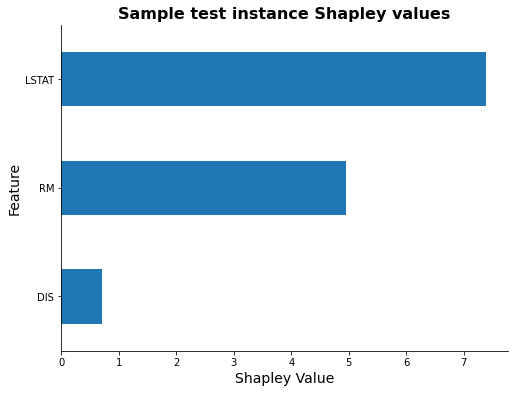

In [17]:
ax = pd.Series(shapley_values).sort_values().plot(kind='barh')

ax.set_xlabel("Shapley Value")
ax.set_ylabel("Feature")
ax.set_title("Sample test instance Shapley values");

Notice that the computed Shapley values aligns with our intuition. `LSTAT` has the highest contribution based on Shapley values. Do note that `LSTAT` refers to % of the population belonging to the lower status. 

<div class="alert alert-info">

**Points for Discussion**
    
The plot showing the Shapley Value for each feature looks similar to a tree feature importance plot. Can you enumerate the differences between the tree feature importance plot and this feature Shapley value plot?

</div>

### Advantages and Disadvantages

Shapley values although is quite a popular method still has its limitations. Let us highlight in this final subsection its advantages and disadvantages. *For more deeper discussion please see Chapter [9.5.4](https://christophm.github.io/interpretable-ml-book/shapley.html#advantages-16) and [9.5.5](https://christophm.github.io/interpretable-ml-book/shapley.html#disadvantages-16)*.

#### Advantages

1. Shapley values is grounded on a **solid theory** which helps distribute the effects fairly. This means that for regulatory requirements such as EU's "right to explanations", Shapley value might be the legally complaint method.
2. Shapley values provide **contrastive explanations**. You can compare the result to a subset or a single data point. Aggregating the result for different instances also allow us to compare how the magnitude of the feature value affects the Shapley value.
3. Although not discussed here, **Shapley values have several axioms** which are: efficiency, symmetry, dummy, and addivity. These axioms can be used to extend how Shapley values may be used, such as adding each values to make the local explanation become global explanation.

#### Disadvantages

1. The main disadvantage of Shapley values is **computational complexity**. Notice that we needed to train a model for each feature subset here. As such, as the features grow in size, the possible coalitions grows exponentially.
2. Shapley values is prone to **misinterpretations**. Shapley value is NOT the difference of the model outcome after removing the feature from model training. It is the contribution of a feature value to the difference between the actual prediction and the naive prediction of the model.
3. Shapley values **cannot be used to hypothesize** changes in the prediction if feature values is changed for a particular instance in your dataset.

<div class="alert alert-success">

**Exercise**

In this demonstration, we showed how we can compute for the Shapley value of each feature value for a sample test dataset instance. Replicate this procedure to get the Shapley values for **ALL** test dataset instances. Get the **mean** Shapley value of each feature then interpret the result. Compare the mean Shapley value of each features with the tree feature importance (obtained from the model containing all the features).


**Steps**
    
1. Modify [this cell](#cell:model-outcomes) to predict on the *test* dataset instead of just a sample instance. You will should get a dictionary with keys as feature subset and values as array of predictions.
2. Iterate through the values of the dictionary then get the Shapley value of each feature for each test sample instance using the `get_shapley_values()` function. Record the result as a list of dictionary of Shapley values for each feature.
3. Construct a dataframe using the result of step 2, then get the mean Shapley values.

</div>

## References

<a name='ref:interpret-ml'></a> [1] Guo, Mengzhuo, et al. "An interpretable machine learning framework for modelling human decision behavior." *arXiv preprint arXiv:1906.01233* (2019).

<a name='ref:molnar'></a> [2] Molnar, Christoph. “Interpretable machine learning. A Guide for Making Black Box Models Explainable”, 2019. https://christophm.github.io/interpretable-ml-book/.

<a name='ref:miller'></a> [3] Miller, Tim. “Explanation in artificial intelligence: Insights from the social sciences.” *arXiv Preprint arXiv:1706.07269.* (2017)

<a name='ref:kim'></a> [4] Kim, Been, Rajiv Khanna, and Oluwasanmi O. Koyejo. “Examples are not enough, learn to criticize! Criticism for interpretability.” *Advances in Neural Information Processing Systems* (2016).

<a name='ref:crisp-dm'></a> [5] Kelleher, John D., Brian Mac Namee, and Aoife D’Arcy. "Machine Learning for Predictive Analytics: The Predictive Data Analytics Project Lifecycle: CRISP-DM." *Fundamentals of machine learning for predictive analytics*, The MIT Press, 2020, pp. 15-17.

<a name='ref:great-ai-debate'></a> [6] NeurIPS 2017. “The Great AI Debate - NIPS2017 - Yann LeCun.” *YouTube*, uploaded by The Artificial Intelligence Channel, 1 February 2018, https://youtu.be/93Xv8vJ2acI.

<a name='ref:bbox-peek'></a> [7] Adadi, Amina, and Mohammed Berrada. "Peeking inside the black-box: a survey on explainable artificial intelligence (XAI)." *IEEE access 6* (2018): 52138-52160.

<a name='ref:rulefit'></a> [8] Friedman, Jerome H., and Bogdan E. Popescu. "Predictive learning via rule ensembles." The Annals of Applied Statistics 2.3 (2008): 916-954.

<a name='ref:med-image'></a> [9] Singh, Amitojdeep, Sourya Sengupta, and Vasudevan Lakshminarayanan. "Explainable deep learning models in medical image analysis." *Journal of Imaging 6.6* (2020): 52.

<a name='ref:shap-how'></a> [10] Mazzanti, Samuele. "SHAP Values Explained Exactly How You Wished Someone Explained to You." *Towards Data Science*, 04 Apr. 2020, https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30

<a name='ref:shapley-handbook'></a> [11] Algaba, Encarnación, Vito Fragnelli, and Joaquín Sánchez-Soriano, eds. *Handbook of the Shapley value*. CRC Press, 2019.
